# RNA Velocity Basics

Here you will learn the basics of RNA velocity analysis.

For illustration, it is applied to endocrine development in the pancreas, with lineage commitment to four major fates: α, β, δ and ε-cells. <br/> 
See [here](https://scvelo.readthedocs.io/scvelo.datasets.pancreas.html) for more details. It can be applied to your own data along the same lines. 

The notebook is also available at
[Google Colab](https://colab.research.google.com/github/theislab/scvelo_notebooks/blob/master/VelocityBasics.ipynb)
and [nbviewer](https://nbviewer.jupyter.org/github/theislab/scvelo_notebooks/blob/master/VelocityBasics.ipynb).

In [1]:
# update to the latest version, if not done yet.
!pip install scvelo --upgrade --quiet

In [2]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.8.12) on 2021-11-02 20:13.


In [3]:
import dynamo

In [4]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization


### Load the Data

The analysis is based on the in-built [pancreas data](https://scvelo.readthedocs.io/scvelo.datasets.pancreas).<br/>
To run velocity analysis on your own data, read your file (loom, h5ad, csv …) to an AnnData object with `adata = scv.read('path/file.loom', cache=True)`. If you want to merge your loom file into an already existing AnnData object, use `scv.utils.merge(adata, adata_loom)`.

In [5]:
adata = dynamo.sample_data.zebrafish()

|-----> Downloading data to ./data/zebrafish.h5ad


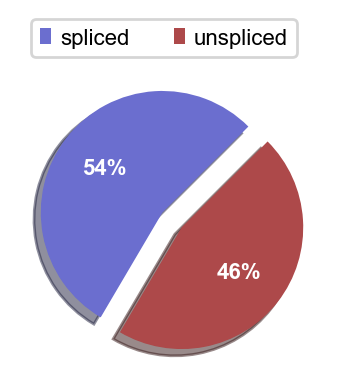

In [6]:
scv.pl.proportions(adata)

### Preprocess the Data

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Filtered out 11388 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Estimate RNA velocity

Velocities are vectors in gene expression space and represent the direction and speed of movement of the individual cells. The velocities are obtained by modeling transcriptional dynamics of splicing kinetics, either stochastically (default) or deterministically (by setting ``mode='deterministic'``). For each gene, a steady-state-ratio of pre-mature (unspliced) and mature (spliced) mRNA counts is fitted, which constitutes a constant transcriptional state. Velocities are then obtained as residuals from this ratio. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

The solution to the full dynamical model is obtained by setting ``mode='dynamical'``, which requires to run
``scv.tl.recover_dynamics(adata)`` beforehand. We will elaborate more on the dynamical model in the next tutorial.

In [8]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


The computed velocities are stored in ``adata.layers`` just like the count matrices. 

The combination of velocities across genes can then be used to estimate the future state of an individual cell. In order to project the velocities into a lower-dimensional embedding, transition probabilities of cell-to-cell transitions are estimated. That is, for each velocity vector we find the likely cell transitions that are accordance with that direction. The transition probabilities are computed using cosine correlation between the potential cell-to-cell transitions and the velocity vector, and are stored in a matrix denoted as velocity graph. The resulting velocity graph has dimension $n_{obs} \times n_{obs}$ and summarizes the possible cell state changes that are well explained through the velocity vectors (for runtime speedup it can also be computed on reduced PCA space by setting `approx=True`).

In [9]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/16 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Project the velocities

Finally, the velocities are projected onto any embedding, specified by `basis`, and visualized in one of these ways: 
- on cellular level with `scv.pl.velocity_embedding`,
- as gridlines with `scv.pl.velocity_embedding_grid`,
- or as streamlines with `scv.pl.velocity_embedding_stream`.

Note, that the data has an already pre-computed UMAP embedding, and annotated clusters. When applying to your own data, these can be obtained with `scv.tl.umap` and `scv.tl.louvain`. For more details, see the [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). Further, all plotting functions are defaulted to using `basis='umap'` and `color='Cell_type'`, which you can set accordingly.

In [23]:
adata

AnnData object with n_obs × n_vars = 4181 × 2000
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'umap', 'Cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

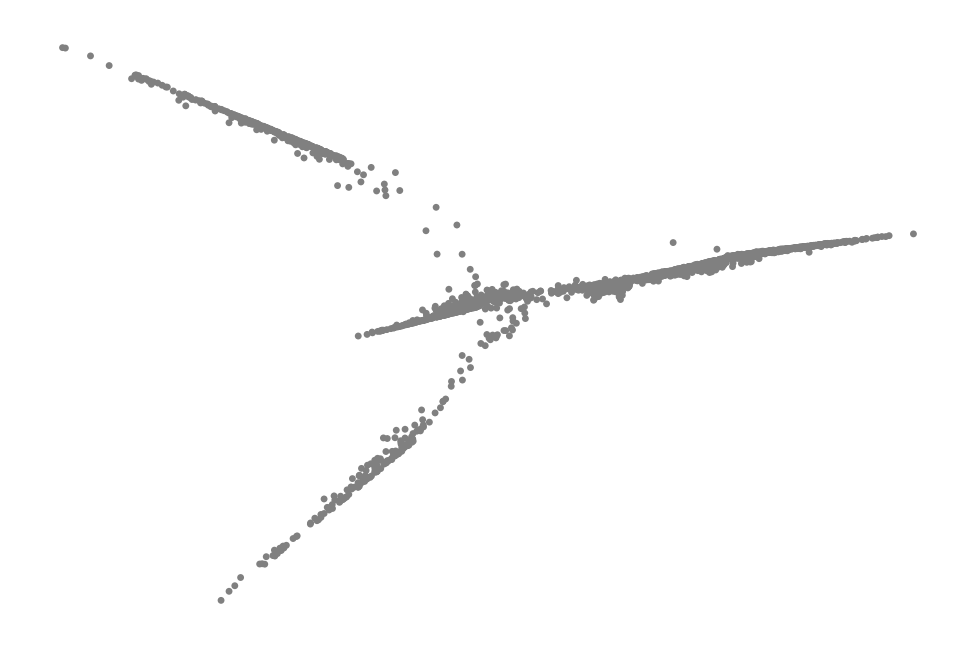

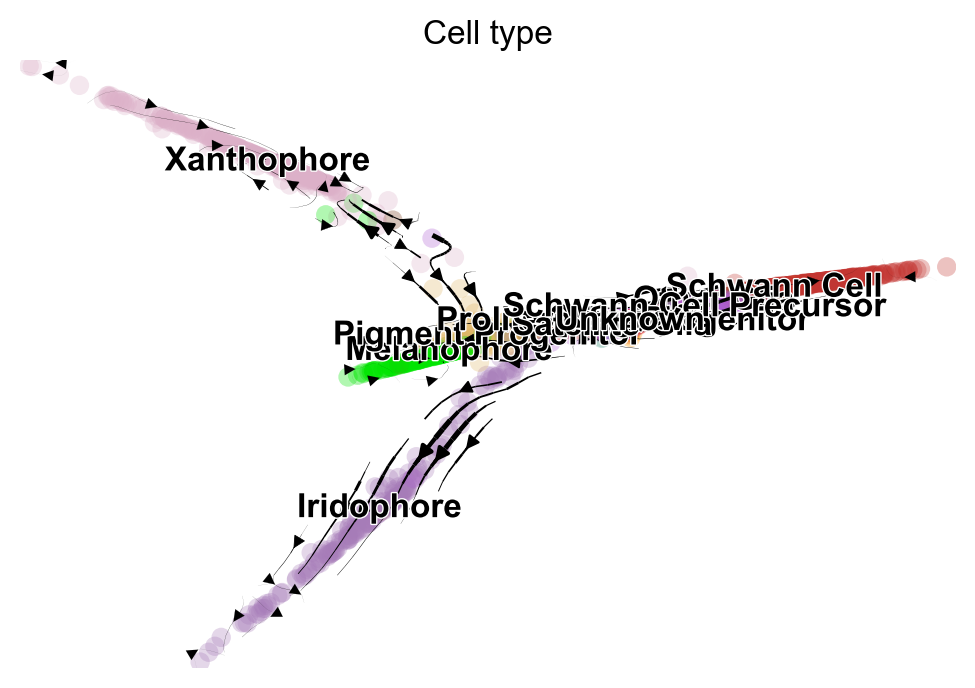

In [24]:
scv.tl.umap(adata)
scv.pl.umap(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap', color="Cell_type")


<Figure size 600x400 with 0 Axes>

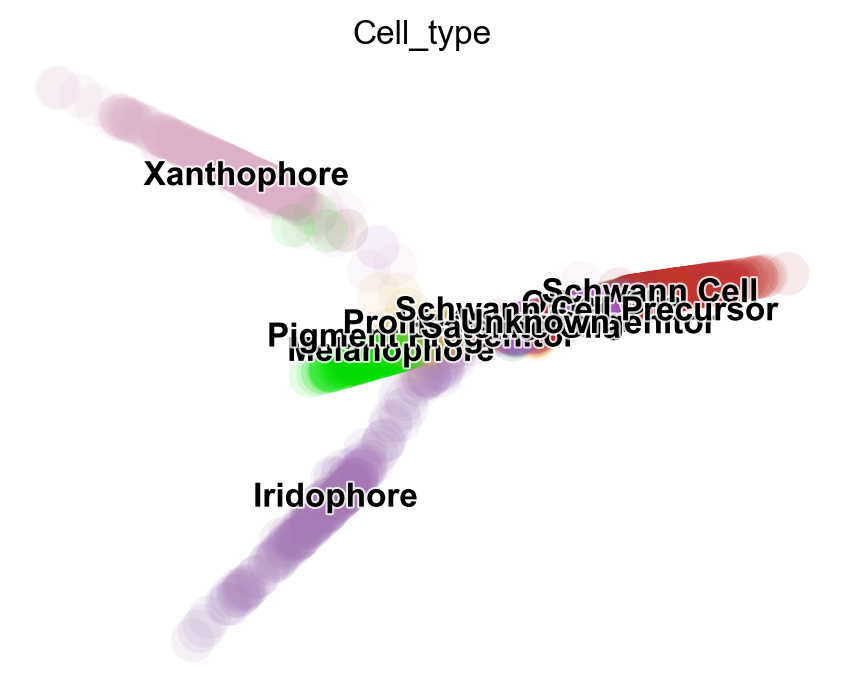

In [20]:
dynamo.pl.umap(adata, color="Cell_type")

The velocity vector field displayed as streamlines yields fine-grained insights into the developmental processes. It accurately delineates the cycling population of ductal cells and endocrine progenitors. Further, it illuminates cell states of lineage commitment, cell-cycle exit, and endocrine cell differentiation. 

The most fine-grained resolution of the velocity vector field we get at single-cell level, with each arrow showing the direction and speed of movement of an individual cell. That reveals, e.g., the early endocrine commitment of Ngn3-cells (yellow) and a clear-cut difference between near-terminal α-cells (blue) and transient β-cells (green).

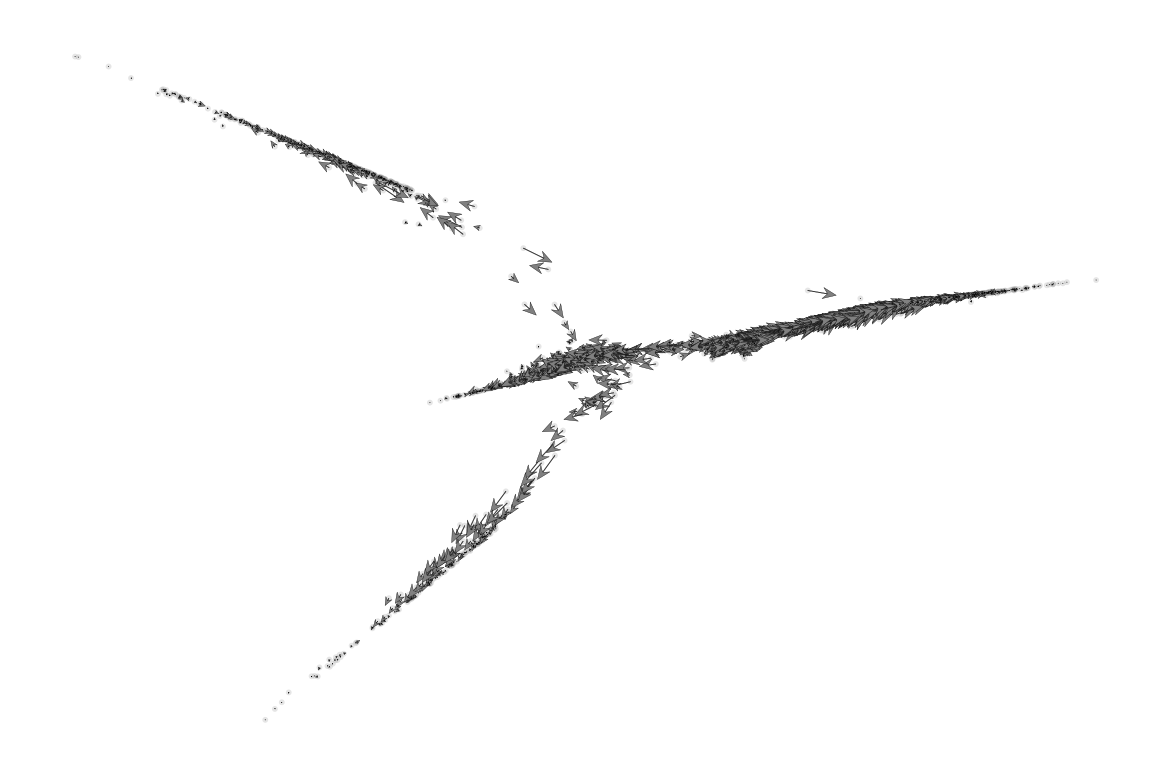

In [21]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)


### Interprete the velocities

This is perhaps the most important part as we advise the user not to limit biological conclusions to the projected velocities, but to examine individual gene dynamics via phase portraits to understand how inferred directions are supported by particular genes. 

See the gif [here](https://user-images.githubusercontent.com/31883718/80227452-eb822480-864d-11ea-9399-56886c5e2785.gif) to get an idea of how to interpret a spliced vs. unspliced phase portrait. Gene activity is orchestrated by transcriptional regulation. Transcriptional induction for a particular gene results in an increase of (newly transcribed) precursor unspliced mRNAs while, conversely, repression or absence of transcription results in a decrease of unspliced mRNAs. Spliced mRNAs is produced from unspliced mRNA and follows the same trend with a time lag. Time is a hidden/latent variable. Thus, the dynamics needs to be inferred from what is actually measured: spliced and unspliced mRNAs as displayed in the phase portrait. 

Now, let us examine the phase portraits of some marker genes, visualized with <br/> 
`scv.pl.velocity(adata, gene_names)` or `scv.pl.scatter(adata, gene_names)`. 

In [29]:
adata

AnnData object with n_obs × n_vars = 4181 × 2000
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'umap', 'Cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [31]:
fig3_si5 = ['mitfa', 'pax3a', 'tfec', 'dct', 'alx4b', 'tyrp1b', 'gpnmb', 'pmela', 'pnp4a']
set(adata.var_names).intersection(fig3_si5)

{'dct', 'gpnmb', 'mitfa', 'pmela', 'pnp4a', 'tfec', 'tyrp1b'}

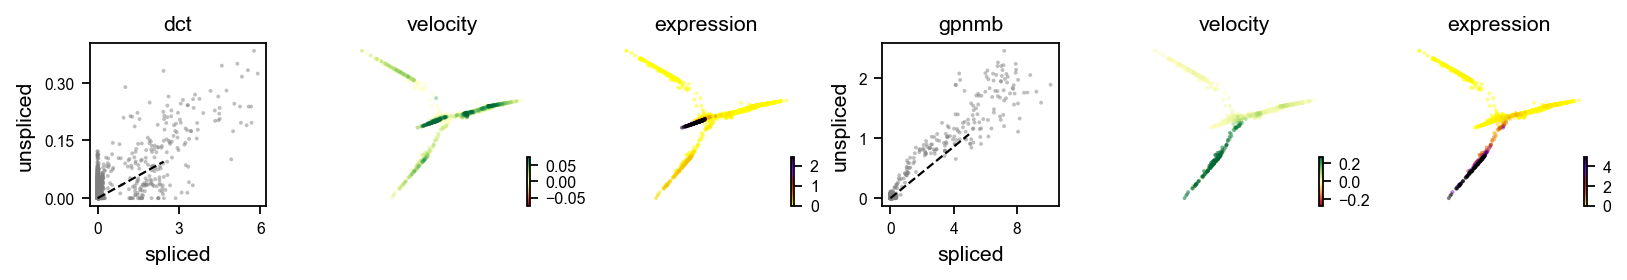

In [32]:
scv.pl.velocity(adata, ['dct', 'gpnmb'], ncols=2)


The black line corresponds to the estimated 'steady-state' ratio, i.e. the ratio of unspliced to spliced mRNA abundance which is in a constant transcriptional state. RNA velocity for a particular gene is determined as the residual, i.e. how much an observation deviates from that steady-state line. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

For instance *Cpe* explains the directionality in the up-regulated Ngn3 (yellow) to Pre-endocrine (orange) to β-cells (green), while *Adk*  explains the directionality in the down-regulated Ductal (dark green) to Ngn3 (yellow) to the remaining endocrine cells.

In [ ]:
scv.pl.scatter(adata, 'Cpe', color=['Cell_type', 'velocity'], 
               add_outline='Ngn3 high EP, Pre-endocrine, Beta')

### Identify important genes
We need a systematic way to identify genes that may help explain the resulting vector field and inferred lineages. 
To do so, we can test which genes have cluster-specific differential velocity expression, being siginificantly higher/lower compared to the remaining population. The module `scv.tl.rank_velocity_genes` runs a differential velocity t-test and outpus a gene ranking for each cluster. Thresholds can be set (e.g. `min_corr`) to restrict the test on a selection of gene candidates.

In [33]:
scv.tl.rank_velocity_genes(adata, groupby='Cell_type', min_corr=.3)

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,Chromaffin,Iridophore,Melanophore,Neuron,Other Glia,Pigment Progenitor,Proliferating Progenitor,Satellite Glia,Schwann Cell,Schwann Cell Precursor,Unknown,Xanthophore
0,slit3,pdzrn3b,lmo7a,pcdh19,COL18,sox4a,erbb3b,arhgef4,nfia,cux1a,DAB2,slc22a2
1,pcdh1b,lpcat1,trpm1b,tshz3b,stard8,igsf11,DAB2,atp1a1b,cadm1b,adgrb1a,fam13b,slc22a7a
2,nrxn1a,syne1b,rgs12b,fam49al,flrt2,slc45a2,mllt4a,bcl11ba,epha7,adgrg6,tm4sf18,slc2a15b
3,palm1a,si:ch211-243a20.3,si:zfos-943e10.1,pcdh1b,entpd3,rab32a,hspg2,mlc1,mag,ptk2ab,prex2,aox5
4,tshz3b,kcnip3b,prdx1,palm1a,ncam1b,mef2cb,mef2aa,cspg5a,timd4,cadm4,mef2aa,zgc:110789


### Velocities in cycling progenitors

The cell cycle detected by RNA velocity, is biologically affirmed by cell cycle scores (standardized scores of mean expression levels of phase marker genes).

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


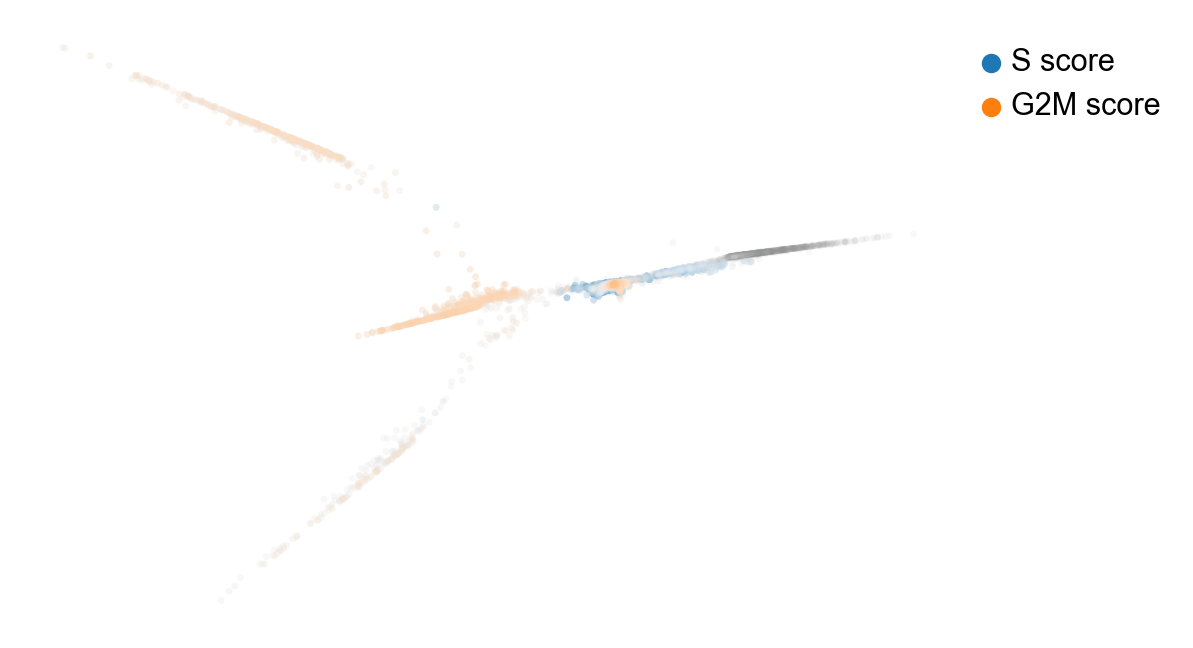

In [35]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])


For the cycling Ductal cells, we may screen through S and G2M phase markers. The previous module also computed a spearmans correlation score, which we can use to rank/sort the phase marker genes to then display their phase portraits. 

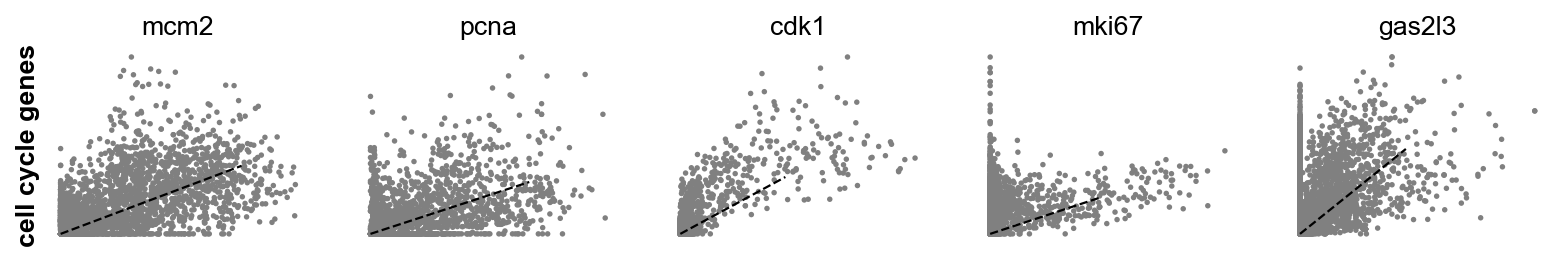

In [36]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)


Particularly *Hells* and *Top2a* are well-suited to explain the vector field in the cycling progenitors. 
*Top2a* gets assigned a high velocity shortly before it actually peaks in the G2M phase. There, the negative velocity then perfectly matches the immediately following down-regulation. 

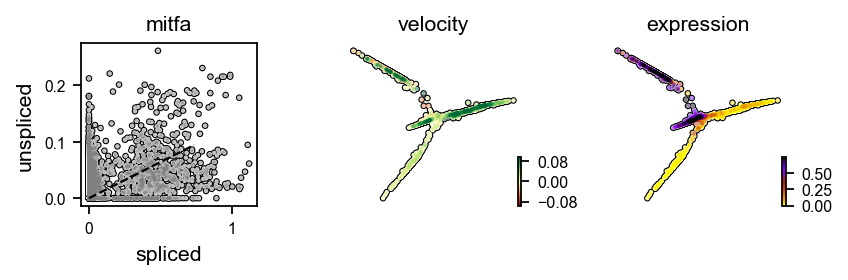

In [38]:
scv.pl.velocity(adata, ['mitfa', 'pax3a'], ncols=2, add_outline=True)

### Speed and coherence
Two more useful stats:<br/> 
- The speed or rate of differentiation is given by the length of the velocity vector. <br/> 
- The coherence of the vector field (i.e., how a velocity vector correlates with its neighboring velocities) provides a measure of confidence.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


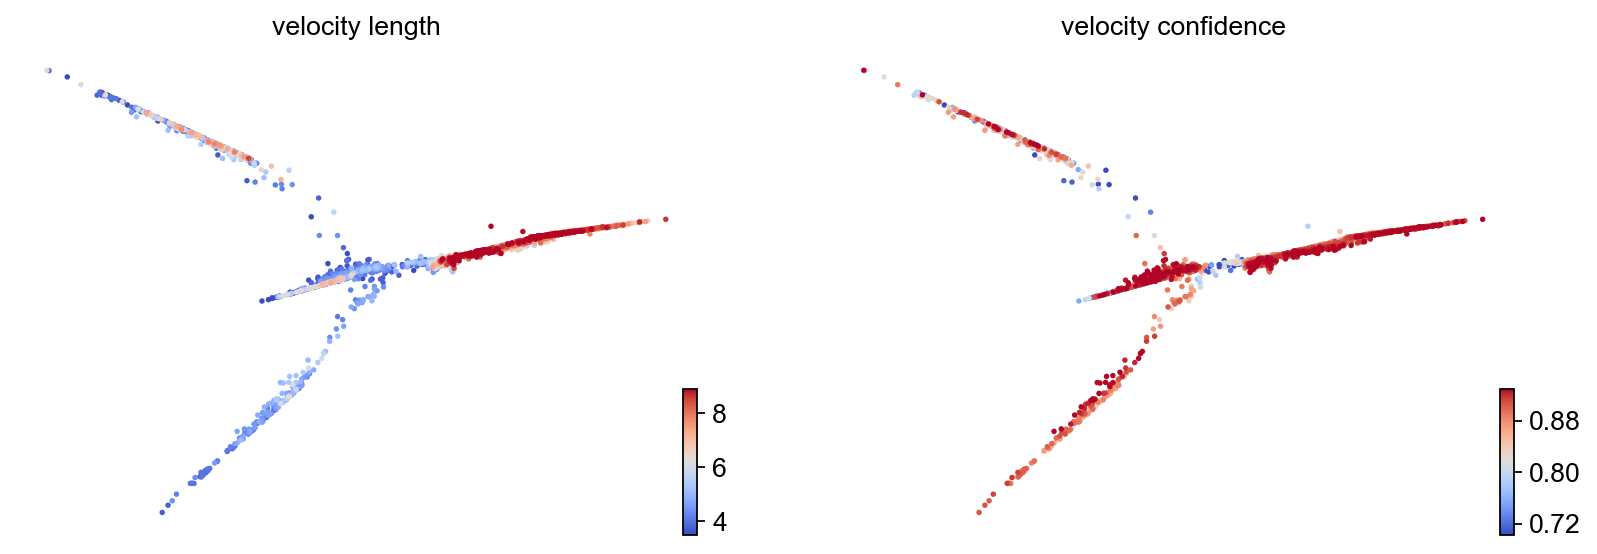

In [39]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])


These provide insights where cells differentiate at a slower/faster pace, and where the direction is un-/determined. 

On cluster-level, we find that differentiation substantially speeds up after cell cycle exit (Ngn3 low EP), keeping the pace during Beta cell production while slowing down during Alpha cell production. 

In [40]:
df = adata.obs.groupby('Cell_type')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)


Cell_type,Chromaffin,Iridophore,Melanophore,Neuron,Other Glia,Pigment Progenitor,Proliferating Progenitor,Satellite Glia,Schwann Cell,Schwann Cell Precursor,Unknown,Xanthophore
velocity_length,5.761765,4.529040,4.084706,4.905255,6.025000,4.135232,5.684814,4.399683,7.494294,8.193619,5.960882,4.847516
velocity_confidence,0.874039,0.870789,0.795781,0.809546,0.772622,0.885446,0.864172,0.874458,0.840751,0.879925,0.819929,0.781090


### Velocity graph and pseudotime
We can visualize the velocity graph to portray all velocity-inferred cell-to-cell connections/transitions. It can be confined to high-probability transitions by setting a `threshold`. The graph, for instance, indicates two phases of Epsilon cell production, coming from early and late Pre-endocrine cells.

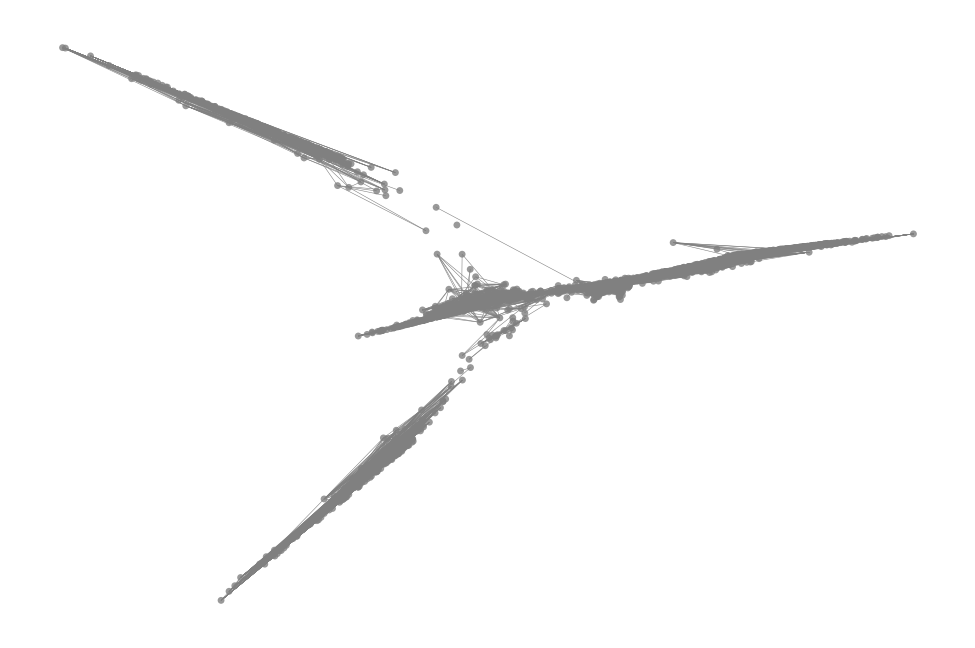

In [41]:
scv.pl.velocity_graph(adata, threshold=.1)

Further, the graph can be used to draw descendents/anscestors coming from a specified cell. Here, a pre-endocrine cell is traced to its potential fate.

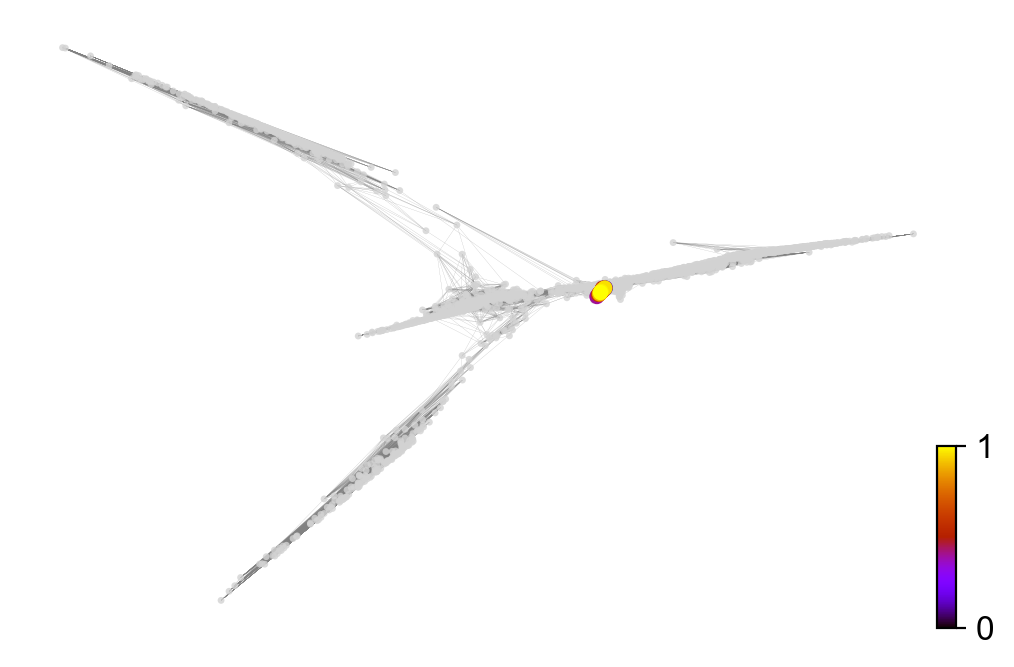

In [42]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)


Finally, based on the velocity graph, a *velocity pseudotime* can be computed. After inferring a distribution over root cells from the graph, it measures the average number of steps it takes to reach a cell after walking along the graph starting from the root cells. 

Contrarily to diffusion pseudotime, it implicitly infers the root cells and is based on the directed velocity graph instead of the similarity-based diffusion kernel.

computing terminal states
    identified 3 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


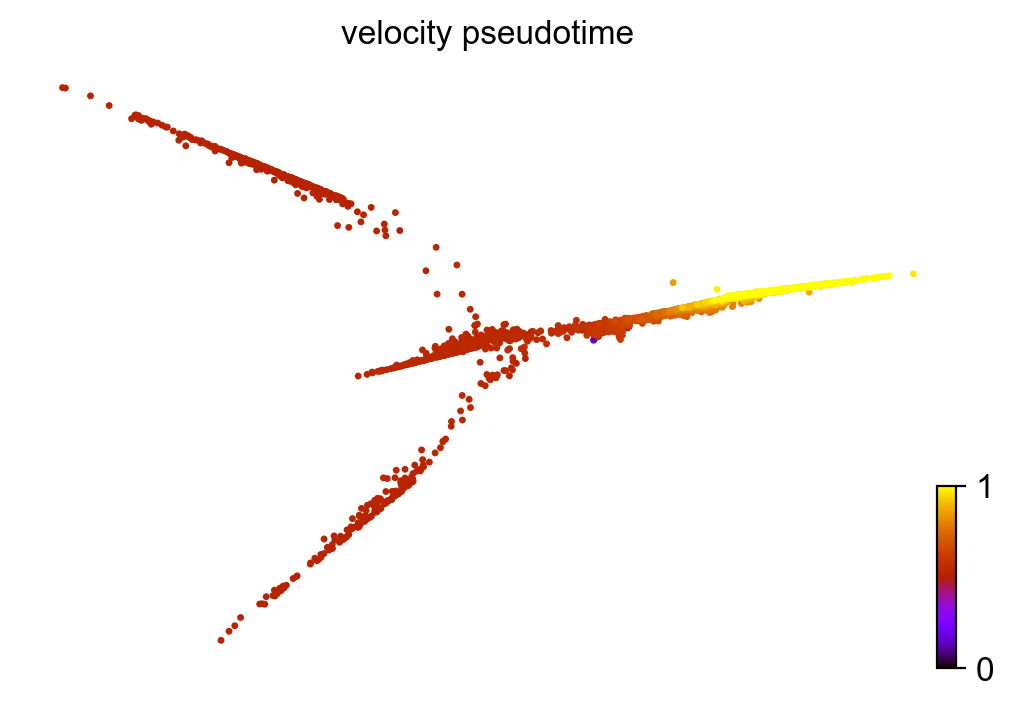

In [43]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')


### PAGA velocity graph
[PAGA](https://doi.org/10.1186/s13059-019-1663-x) graph abstraction has benchmarked as top-performing method for trajectory inference. It provides a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters. Here, PAGA is extended by velocity-inferred directionality.

In [ ]:
# PAGA requires to install igraph, if not done yet.
!pip install python-igraph --upgrade --quiet

In [44]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='Cell_type')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,Chromaffin,Iridophore,Melanophore,Neuron,Other Glia,Pigment Progenitor,Proliferating Progenitor,Satellite Glia,Schwann Cell,Schwann Cell Precursor,Unknown,Xanthophore
Chromaffin,0,0,0,0,0,0,0,0,0,0,0,0
Iridophore,0,0,0,0,0,0.026,0,0,0,0,0,0
Melanophore,0,0,0,0,0,0.064,0,0,0,0,0,0
Neuron,0.045,0,0,0,0,0.024,0,0,0.098,0,0,0
Other Glia,0,0,0,0,0,0,0,0,0.14,0,0,0
Pigment Progenitor,0,0,0,0,0,0,0,0,0,0,0,0
Proliferating Progenitor,0,0,0,0,0,0,0,0,0,0.22,0,0
Satellite Glia,0,0,0,0.026,0,0,0,0,0,0,0,0
Schwann Cell,0,0,0,0,0,0,0,0,0,0,0,0
Schwann Cell Precursor,0,0,0,0,0,0,0,0,0.24,0,0,0


This reads from left/row to right/column, thus e.g. assigning a confident transition from Ductal to Ngn3 low EP. 

This table can be summarized by a directed graph superimposed onto the UMAP embedding.

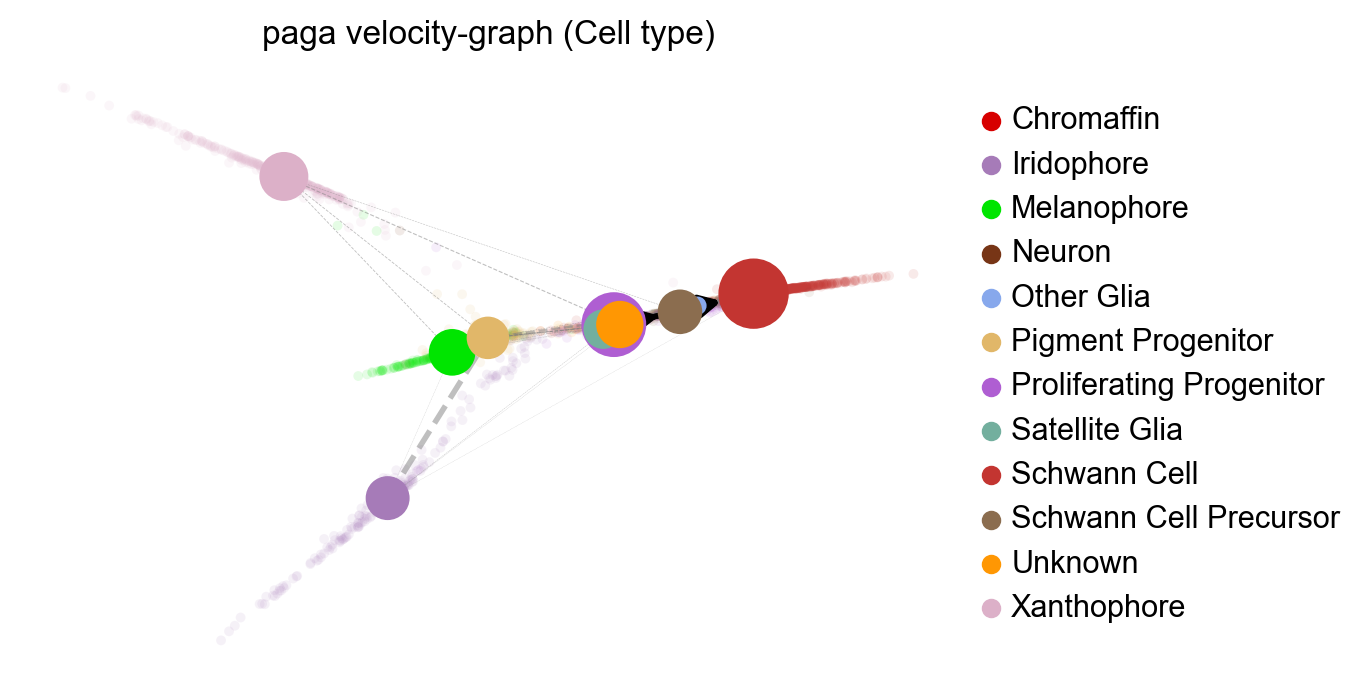

In [45]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)